# Prepare customized dataset with `torch.utils.data.Dataset`

- images path: ../samples/qq
- image label: 4 characters in range `a-z`

In [1]:
import os
import torch
from torch.utils.data import Dataset

In [47]:
IMAGE_W, IMAGE_H = 120, 60

NUM_CLASS = ord('z')-ord('a')+1
NUM_CHAR = 4
print(NUM_CLASS)

26


In [55]:
# 1. Customized Dataset
import random
import cv2
import numpy as np


def encode(label):
    '''Encode label.'''
    res = []
    for c in label:
        item = [0] * NUM_CLASS
        item[ord(c)-ord('a')] = 1
        res.extend(item)
    return torch.Tensor(res)


def decode(tensor):
    '''Decode tensor to label.'''
    codes = tensor.numpy()
    label = ''
    for i in range(NUM_CHAR):
        item = codes[i*NUM_CLASS:(i+1)*NUM_CLASS]
        idx = np.argmax(item)
        label += chr(ord('a')+idx)
    return label


class CaptchaData(Dataset):
    def __init__(self, root:str, train:bool=True, create_index:bool=False):
        '''User defined dataset.

        Args:
            root (str): Image path.
            train (bool, optional): Training set if true, otherwise testing set. Defaults to True.
            create_index (bool, optional): Create index file for training / testing set. Defaults to False.
        '''
        super().__init__()
        self.root = root

        # create image index file only once
        top = os.path.dirname(root)
        train_index_file = os.path.join(top, 'train.index')
        test_index_file = os.path.join(top, 'test.index')
        if create_index:
            self.__create_index_files(train_index_file, test_index_file, 0.9)
        
        # data items, e.g., ['abcd', ..., ]
        self.labels = self.__load_labels(train_index_file if train else test_index_file)


    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx:int):
        label = self.labels[idx]
        return self.__load_image(label), encode(label)

    
    def __load_image(self, label):
        '''Load image data based on label. Note the conversion from opencv space to pytorch.'''
        img_path = os.path.join(self.root, f'{label}.jpg')
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR -> RGB
        img = cv2.resize(img, (IMAGE_W,IMAGE_H))
        img = img.transpose(2, 0, 1) # shape: H, W, C -> C, H, W
        return torch.from_numpy(img/255.0).float()


    def __load_labels(self, index_file):
        '''Load labels from index file.'''
        # load labels from index file
        with open(index_file, 'r') as f: samples = f.read().splitlines()
        return samples


    def __create_index_files(self, 
            train_index_file:str, 
            test_index_file:str, 
            train_rate:float=0.9):
        # load and shuffle all captcha images
        labels = [filename[0:NUM_CHAR] for filename in os.listdir(self.root) if filename.endswith('.jpg')]
        random.shuffle(labels)

        # split into training and testing set
        pos = int(len(labels)*train_rate)
        with open(train_index_file, 'w') as f: f.write('\n'.join(labels[:pos]))
        with open(test_index_file, 'w') as f: f.write('\n'.join(labels[pos:]))


In [56]:
run_once = False
train_dataset = CaptchaData('../samples/qq', train=True, create_index=run_once)
test_dataset = CaptchaData('../samples/qq', train=False, create_index=run_once)

In [57]:
print(len(train_dataset), len(test_dataset))

90573 10064


torch.Size([3, 60, 120]) torch.Size([104])


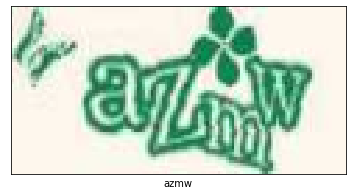

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

for image, label in train_dataset:
    print(image.size(), label.size())

    # show image
    plt.imshow(image.numpy().transpose(1,2,0)) # C, H, W -> H, W, C
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(decode(label))
    plt.show()
    
    break

In [67]:
# 2. Data Loader
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(len(train_data_loader), int(len(train_dataset)/BATCH_SIZE))

2831 2830


In [69]:
for batch_img, batch_label in train_data_loader:
    print(batch_img.size())
    print(batch_label.size())
    for img in batch_img:
        print(img.size())
        break
    break

torch.Size([32, 3, 60, 120])
torch.Size([32, 104])
torch.Size([3, 60, 120])
